# Auto-Regressive assimilation with EnIF

We illustrate `EnIF` methodology and the API through the Auto-Regressive-1 (AR-1) model.
The AR-1 is defined by
$$u_t = \phi u_{t-1} + \epsilon,~~
 \epsilon\sim N(0,1) $$
and has a tri-diagonal sparse precision matrix.

We will illustrate both the **high-level** API of EnIF, and also the **low-level** API.

## Imports

In [1]:
import numpy as np
np.set_printoptions(precision=3, suppress=True)
import scipy.sparse as sp
from scipy.stats import norm
import matplotlib.pyplot as plt
from graphite_maps.precision_estimation import precision_to_graph
from graphite_maps.enif import EnIF

We will repeatedly plot
- a realization
- an ensemble
- the ensemble mean
- the difference between posterior and prior mean

we thus create a function for this

In [2]:
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_ensemble(Ensemble, d, prior_mean=None):
    n, p = Ensemble.shape
    u_position = [j for j in range(p)]
    ind_obs = np.rint(p / 2).astype(int) - 1
    ensemble_mean = np.array(Ensemble.mean(axis=0))
    num_plots = 3 if prior_mean is None else 4
    
    fig = plt.figure(figsize=(16, 4))
    fig.suptitle('Ensemble inspection & observation', fontsize=16)

    ax = fig.add_subplot(1,num_plots,1)
    ax.plot(u_position, Ensemble[0,:])
    ax.plot(ind_obs, [d], marker='*', ls='none', ms=20)
    ax.set_title('Realization #1')
    
    ax = fig.add_subplot(1,num_plots,2)
    for i in range(n):
        ax.plot(u_position, Ensemble[i,:], label= "realization {ind}".format(ind=i), color=COLORS[0], alpha=0.1)
    ax.set_title('All realizations')
    ax.plot(ind_obs, [d], marker='*', ls='none', ms=20, color=COLORS[1])
    ax_min, ax_max = ax.get_ylim()  # Get y-limits
    
    ax = fig.add_subplot(1,num_plots,3)
    ax.plot(u_position, ensemble_mean)
    ax.plot(ind_obs, [d], marker='*', ls='none', ms=20)
    ax.set_title('Ensemble mean')

    if num_plots == 4:
        ax = fig.add_subplot(1,num_plots,4)
        ax.plot(u_position, ensemble_mean - prior_mean)
        ax.set_title('Posterior mean - prior mean')
    plt.show()

## Data setup: Auto-regressive simulation

We define the parameters of the ensemble based data assimilation with the AR-1
- `n`: ensemble or sample size. Increasing will increase the quality of the solution
- `p`: the number of AR-1 time-steps, here the dimensions of the problem. Increasing yields a more difficult problem. Traditional ensemble based methods would use localization to deal with high `p`.
- `phi`: between `-1` and `1`. `0` yields white noise without dependence. When `abs(phi)` is close to `1` there is strong dependence between dimensions.
- - Suggest to try `phi in [-0.99, 0.5, 0, 0.5, 0.99]` and inspect differences.

In [3]:
# Define parameters
n = 100  # Sample size
p = 1000   # Dimension
phi = 0.99

In [4]:
# Simulate data
def rar1(T, phi):
    """simulate auto-regressive-1.
    The first element is simulated from stationary distribution.
    """
    x = np.empty([T])
    x[0] = np.random.normal(0, 1 / np.sqrt(1 - phi**2))
    for i in range(1, T):
        x[i] = phi * x[i - 1] + np.random.normal(0, 1)
    return x

np.random.seed(42)
U = np.array([rar1(T=p, phi=phi) for _ in range(n)])

We here know the precision exactly, so we may compare our estimates. Note we derive the graph `Graph_u` from the precision, which we would normally just know apriori, while `Prec_u` would often (not always) be unknown.

In [5]:
# create AR-1 precision matrix
Prec_u = sp.diags(
    [np.repeat(-phi, p-1), np.concatenate(([1.0], np.repeat(1.0+phi**2, p-2), [1.0])), np.repeat(-phi, p-1)], 
    [-1,0,1], shape=(p, p), 
    format='csc'
)

# create corresponding graph -- often we only know this
Graph_u = precision_to_graph(Prec_u)

Create observations, `d`, that are associated with `u`.
We here pass a linear map `H` so that we model $d=Hu+\epsilon$, and $\epsilon$ has known precision.
Note that `H` may be learnt from data using the `fit_H` function.
We must then pass realizations `U` and simulated responses `Y`.

In [6]:
# create observation
d = np.array([5.0])
sd_eps = 1
H = np.array([0] * p, ndmin=2)
H[0, np.rint(p / 2).astype(int) - 1] = 1  # middle sencor
H = sp.csc_matrix(H)
Prec_eps = np.array([1/sd_eps**2], ndmin=2)
Prec_eps = sp.csc_matrix(Prec_eps)

Let's inspect the sample from the prior, and the observation `d`

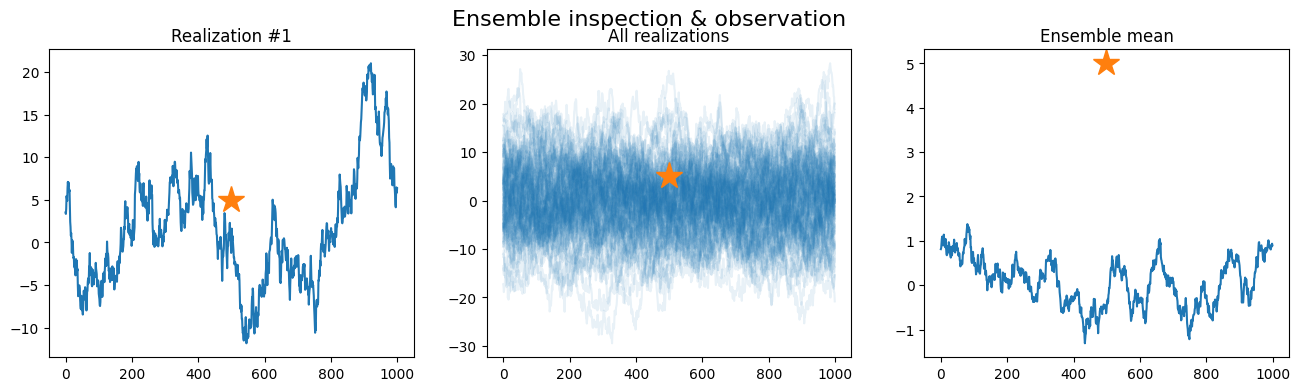

In [7]:
plot_ensemble(U, d)

## EnIF high-level API

The high-level API consists of initialization, usually with a `Graph_u`, the noise precision `Prec_eps` and possibly the map `H`.
Then only two functions are needed `fit` and `transport` to arrive an updated (or analysed) ensemble.
To think of these know that 
- `fit` estimates a GMRF model w.r.t. the graph `Graph_u`, and learns a sparse affine map `H`. If `Prec_u` or `H` are passed, they are not re-fitted, but the low-level API can be used to update these if need be.
- `transport` takes the prior ensemble `U` and "transports" each realization to a realization of the posterior under the fitted GMRF and `H` model. More on the details here in the low-level API section.

In [8]:
gtmap = EnIF(Graph_u = Graph_u, Prec_eps=Prec_eps, H=H)
gtmap.fit(U)
U_posterior = gtmap.transport(U, d)

Learning precision Cholesky factor row-by-row: 100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 472.85it/s]

H mapping exists. Use `fit_H` to refit if necessary


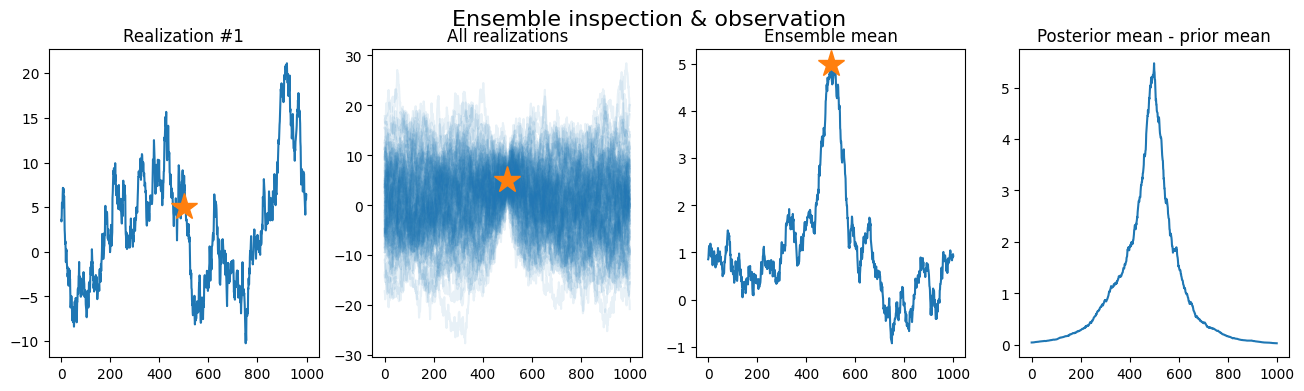

In [9]:
prior_mean = np.array(U.mean(axis=0))
plot_ensemble(U_posterior, d, prior_mean)

## EnIF low-level API

### Sanity check #1: Equality of results

We now illustrate the low-level API, and check that it gives the same result as the high-level.

In [10]:
gtmap_lowlevel = EnIF(Graph_u = Graph_u, Prec_eps=Prec_eps, H=H)

#### Fit
When we call `fit`, we may estimate `Prec_u` as a GMRF w.r.t. `Graph_u`.
Also during `fit`, the mapping `H` may be estimated using `fit_H` that employes the LASSO for learning a sparse representation.

In [11]:
gtmap_lowlevel.fit_precision(U)
if gtmap_lowlevel.H is None:
    gtmap_lowlevel.fit_H(U, U@H.T) # simulations Y = U@H.T

Learning precision Cholesky factor row-by-row: 100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 475.90it/s]


#### Transport

The name `transport` comes from the field of measure-transport.
It does make sense in this context, because the function indeed transports each realization of prior to a realization of the posterior w.r.t. the GMRF on $(u,d)$ estimated by `fit`.

`transport` consists of three functions
- `pushforward_to_canonical`: transport realizations to "canonical" space
- `update_canonical`: update each canonical realization to a realization from the posterior, _and_ update the precision `Prec_u`
- `pullback_from_canonical`transport realizations back to physical space

In [12]:
canonical = gtmap_lowlevel.pushforward_to_canonical(U)
canonical_posterior = gtmap_lowlevel.update_canonical(canonical, d)
U_posterior = gtmap_lowlevel.pullback_from_canonical(canonical_posterior)

Note that `transport` could have used the Kalman-filter equations (conditioning with a multivariate Gaussian in the mean-precision parametrization).
It is however much more numerically efficient (and stable) to employ the Information-filter equations (conditioning with a multivariate Gaussian in the canonical parametrization) when working with a GMRF.

We plot to check the results are like before

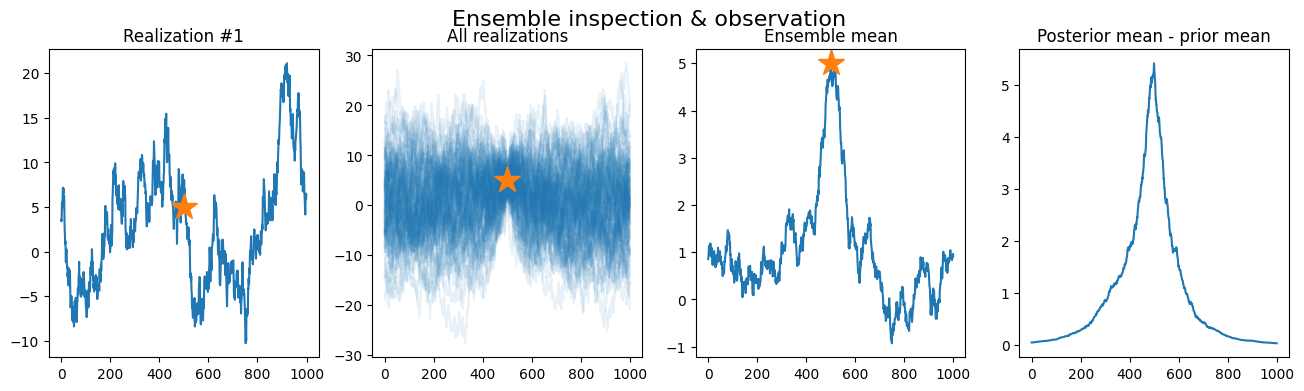

In [13]:
plot_ensemble(U_posterior, d, prior_mean)

The results look identical.

### Sanity check #2: Using true precision

For this case, we do indeed have access to the true prior precision of the AR-1 process.
It is possible to pass this to `EnIF` upon initialization, and if `H` too is provided it is not necessary to run `fit`.
The case of a known precision is sometimes known, e.g. when doing pure parameter estimation, the prior we are sampling from can indeed be known, and is often transformed (for good reasons) to a multivariate standard normal.

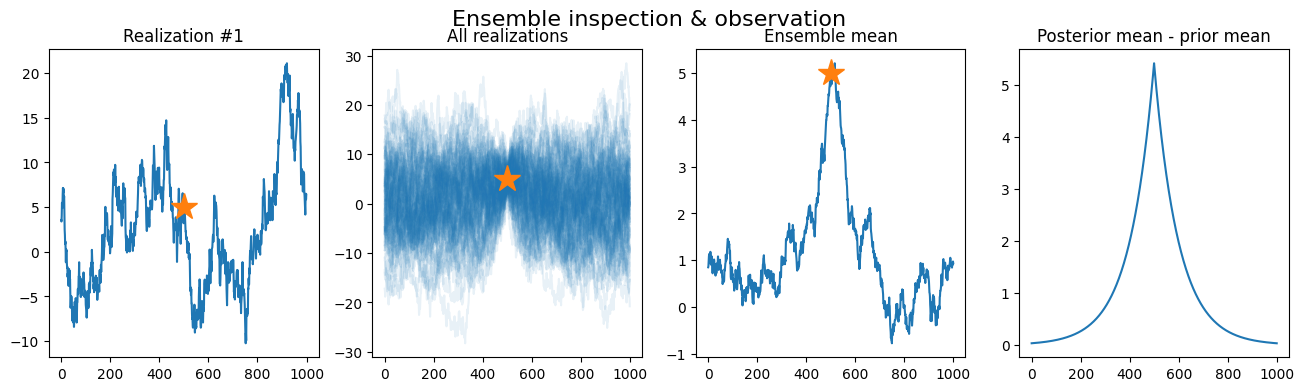

In [14]:
gtmap_prec_known = EnIF(Prec_u = Prec_u, Prec_eps=Prec_eps, H=H)

U_posterior = gtmap_prec_known.transport(U, d)

plot_ensemble(U_posterior, d, prior_mean)

The results are _almost_ identical.
Note however that there is zero noise in the update.
This is because we have not estimated anything from data -- both `Prec_u` and `H` was provided apriori, exactly defining the Gaussian on $(u,d)$.

### Sanity check #3: Pullback of pushforward without update at canonical

We just decomposed `transport` to its three main parts, a pushforward, an update, and a pullback.
It is reasonable to think that if we skip the `update` in the middle,

In [15]:
gtmap_pullpush = EnIF(Prec_u = Prec_u, Prec_eps=Prec_eps, H=H)
canonical = gtmap_pullpush.pushforward_to_canonical(U)
U_posterior = gtmap_pullpush.pullback_from_canonical(canonical)

then the pullback of what we pushforwarded, should be the same as what we input

In [16]:
np.allclose(U, U_posterior, atol=1e-12)

True

which indeed seems to be the case.

## Estimating a sparse linear map

If `H` is not given, then it must be estimated from data `U` and `Y`.
In our case, we have

In [17]:
Y = U@H.T

as simulations are, for this instance, without the observation error noise.
We seek a linear map that learns
$$H = E[\nabla_u h(u)]$$ 
for some conceptual potentially non-linear map $h:u\mapsto y$.
Furthermore, we seek a sparse representation `H`, so that the posterior `Prec_u` retains sparsity.
To this end, `fit_H` implements linear L1 regression

In [18]:
gtmap_uninformed = EnIF(Graph_u=Graph_u, Prec_eps=Prec_eps)

Note that neither `Prec_u` or `H` is passed.
As such, they should both be learnt from data.

In [19]:
gtmap_uninformed.fit(U, Y)

Learning sparse linear map for each response: 100%|██████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.27it/s]


Print the true and the (hopefully sparse) learnt map, to see if it looks correct

In [20]:
print("Original sparse matrix")
print(H) # true (unknown) map
print("Estimated sparse matrix")
print(gtmap_uninformed.H) # estimated (sparse) map

Original sparse matrix
  (0, 499)	1
Estimated sparse matrix
  (0, 498)	0.005243402056342818
  (0, 499)	0.993880120645363


As we see, the sparsity structure has been identified, and the value is very close to `1`.
We may then employ it for `transport` of the prior ensemble to a posterior ensemble

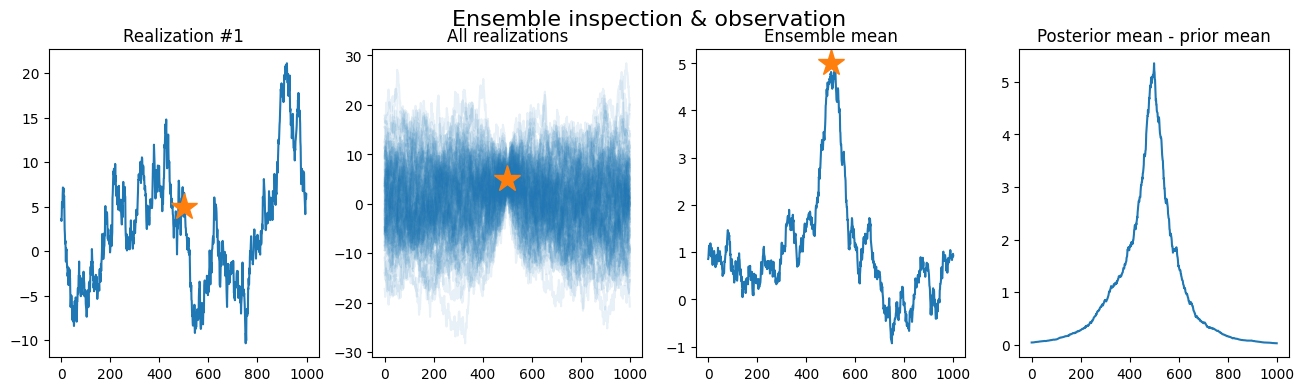

In [21]:
U_posterior = gtmap_uninformed.transport(U, d)
plot_ensemble(U_posterior, d, prior_mean)